<h1>Coursera capstone final project : Amsterdam Housing Market</h1>

<h3>Introduction: Business Problem</h3>

Amsterdam is the capital of the Netherlands, It is a well known tourist destination, receiving more than 40 millions visitors a year, with a large number of cultural attractions per capita. Amsterdam is also well known for its rising housing prices: since 2015, prices have steadily increased every year, with an increase of about 80% between 2014 and 2020. In this capstone project we will explore the Amsterdam housing market, with a particular focus on apartment prices. We will use linear regression models on the Amsterdam housing data to predict the price from house features such as surface area. We will then combine Amsterdam the house price dataset with Foursquare location data, setting out to answer the following business question: **Can we improve house price predictions using Foursquare location data?**. In answering this question we will run a clustering algorithm on Foursquare location data to distinguish areas with similar features. We then use Amsterdam's postcodes and try to use the cluster-labels to improve the linear regression prediction. We then use the Foursquare data in other ways to try to reach the same goal, namely, we will run the linear regression on the main cluster only, give that we will find out there is one cluster significantly bigger than the others. 

Whether you are a stakeholder looking to invest in the Amsterdam housing market, a single buyer looking to check if an asking price is convenient or not or seller looking to set a competitive yet rewardable price for the house you want to sell, the results of this project will surely be of interest to you.

Let's start by importing the necessary libraries:

In [1]:
import requests # pip install requests

from bs4 import BeautifulSoup as bs # pip install beautifulsoup4

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import os

import itertools

from matplotlib.ticker import NullFormatter

import matplotlib.ticker as ticker

from sklearn import preprocessing

pd.options.mode.chained_assignment = None

We allow inline figures with this matplotlib command:

In [2]:
%matplotlib inline

As part of the data inspection, we do not want to limit the amount of displayed rows or columns in the dataset:

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

<h3>First part of the project</h3>

<h3>Data section</h3>

Amsterdam is administratively divided into 8 large districts or boroughs. Each district is then subdivided into neighbourhoods, with 107 neighbourhoods in total. Alternatively, Amsterdam can be divided into postcode areas. Due to the difficulty to find consistent data on the neighbourhoods, we have decided to run a clustering algorithm on the Foursquare data using the postcode areas as geolocations. We use 72 postcode areas, and for each postcode we extracted its approximate centre location from Google maps. Due to its geographically separate location we have excluded Amsterdam Zuid-Oost from our study. 

For the housing market data, we have gathered and used data from funda.nl, the main website for housing in the Netherlands and association of housing agents. As funda.nl has a protection mechanism and it is not allowed to scrape data from the site, we have used only the data present in the main pages for the Amsterdam listing, this includes only: address, postal code, m2 of living area, number of rooms and price. We will see that even with this limitation, we are still able to make reasonable predictions with this limited feature count. 

At the time of data collection (end December 2020) there were about 2500 apartments for sale in Amsterdam and about 500 houses. Since houses have an additional feature (plot size) and apartments do not, we have decided to focus on apartment data only. We have then combined the two datasets in order to try to answer the business question and find out if it is possible to improve the prediction by combining the Foursquare data to the housing data.

In the following cell we extract the data from the webpages that we have previously downloaded and parse them with BeautifulSoup library:

In [4]:
import glob

Addresses = []
Postcodes = []
Prices = []
Living_areas = []
Plot_sizes = []
Rooms = []

dir_path = "/Users/HomeJahzz/Desktop/U-PROJECT/FUNDA_SOUP"

for file_name in glob.glob(os.path.join(dir_path, "*.html")):
    my_data = (file_name)
    soup = bs(open(my_data, "r").read())
    
    addresses = soup.find_all("h2", attrs={"class": "search-result__header-title fd-m-none"})
    for item in addresses:
        Addresses.append(item.get_text()[15:-9])
        
    postcodes = soup.find_all("h4", attrs={"class": "search-result__header-subtitle fd-m-none"})
    for item in postcodes:
        Postcodes.append(item.get_text().split()[0])

    prices = soup.find_all("span", attrs={"class": "search-result-price"})
    for item in prices:
        if item.get_text().split()[0] != '€':
            Prices.append(-100)
        else:
            s = item.get_text().split()
            if s[2] in ('k.k.', 'v.o.n.'):
                p = s[1]
                p = p.replace(',', '')
                Prices.append(int(p))
    
    div_container = soup.find_all("div", attrs={"class": "search-result-info"})

    for i in range(0,len(div_container)):
            itt = div_container[i].find_all("li")
            if len(itt) != 0:
                Rooms.append(int(itt[1].get_text().split()[0]))
                itt2 = itt[0]
                itt3 = itt2.find_all("span")
                if len(itt3) == 2:
                    pp0 = itt3[0].get_text().split()[0]
                    pp0 = pp0.replace(',', '')
                    Living_areas.append(int(pp0))
                    pp1 = itt3[1].get_text().split()[0]
                    pp1 = pp1.replace(',', '')
                    Plot_sizes.append(int(pp1))
                else:
                    pp0 = itt3[0].get_text().split()[0]
                    pp0 = pp0.replace(',', '')
                    Living_areas.append(int(pp0))
                    Plot_sizes.append(int(pp0))

We then create the dataframe that we will use for the project and populate it:

In [5]:
df_houses_raw = pd.DataFrame(columns=['Address', 'Postcode','Living_area','Plot_size','Rooms','Price'])

df_houses_raw['Address'] = Addresses

df_houses_raw['Postcode'] = Postcodes

df_houses_raw['Living_area'] = Living_areas

df_houses_raw['Plot_size'] = Plot_sizes

df_houses_raw['Rooms'] = Rooms

df_houses_raw['Price'] = Prices

The dataframe contains 2859 entries and has 6 columns: Address, Postcode, Living area m2, plot size m2, number of rooms and price:

In [6]:
df_houses_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Address      2859 non-null   object
 1   Postcode     2859 non-null   object
 2   Living_area  2859 non-null   int64 
 3   Plot_size    2859 non-null   int64 
 4   Rooms        2859 non-null   int64 
 5   Price        2859 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 134.1+ KB


<h3>Data cleaning:</h3>

We exclude the cells that have -100 as price (we have previously set this value to items where the price was
unavailable during data gathering)

In [7]:
df_houses = df_houses_raw[df_houses_raw['Price'] != -100]

We have now 2848 items in the dataframe:

In [8]:
df_houses.shape

(2848, 6)

Next we check for duplicates and remove them:

In [9]:
df_houses = df_houses.drop_duplicates()

We can see we have cleaned out the 4 duplicates:

In [10]:
df_houses.shape

(2844, 6)

We will now create a feature-limited dataframe without location data, for use in modelling without access to neighbourhood information. Since we made the decision to focus on apartments only, we will exclude the plot size feature. We thus work with two features (Living area and Rooms) and a target (Price)

In [11]:
cdf = df_houses[['Living_area','Rooms','Price']]
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2844 entries, 0 to 2858
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Living_area  2844 non-null   int64
 1   Rooms        2844 non-null   int64
 2   Price        2844 non-null   int64
dtypes: int64(3)
memory usage: 88.9 KB


<h3>Exploratory Data Analysis:</h3>

We first make some simple statistics. The mean living area is approximately 100m2, going from as low as 10m2 to as high as 500m2. The number of rooms ranges from 1 to 16:

In [12]:
cdf.describe().round()

,Living_area,Rooms,Price
count,2844.0,2844.0,2844.0
mean,97.0,3.0,663093.0
std,51.0,1.0,547083.0
min,10.0,1.0,100000.0
25%,60.0,3.0,350000.0
50%,86.0,3.0,500000.0
75%,120.0,4.0,775947.0
max,500.0,16.0,11500000.0


With the following cell we inspect the dataframe. In particular, we plot the number of apartments for sale for each postcode in descending order. From this we can see that the data has a nice "inverse proportional-like" shape. Two postcodes had as many as 151 and 113 apartments for sale (the area near to the ARTIS zoo and the area in Amsterdam Noord close the Eye Filmmuseum):

In [ ]:
n_by_postcode = df_houses.groupby("Postcode")["Price"].count()
n_by_postcode_sorted = n_by_postcode.sort_values(ascending=False).reset_index(drop=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]),
 <a list of 70 Text major ticklabel objects>)

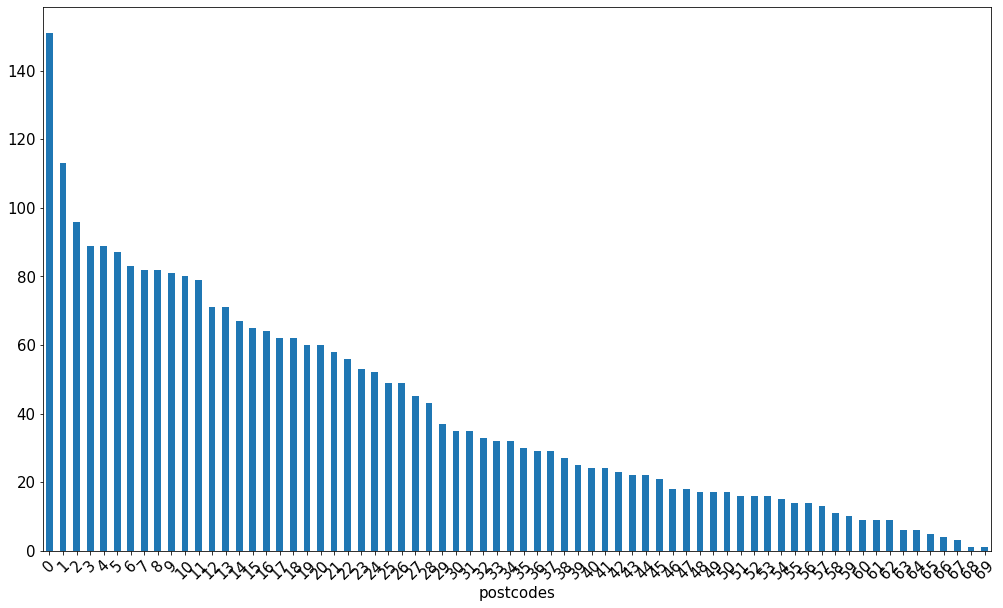

In [112]:
plt.figure(figsize=(17,10))
n_by_postcode_sorted.plot.bar()
plt.xlabel('postcodes', fontsize=15)
plt.xticks(rotation=45)

We can see that we have 70 different postcodes represented in the data set, so nearly all of the 72 in total in Amsterdam:

In [14]:
n_by_postcode.shape

(70,)

Next, we explore the features Living area and Price, by plotting distribution plots we can see that both features have a highly left-skewed distribution:

Text(0.5, 0, 'm2')

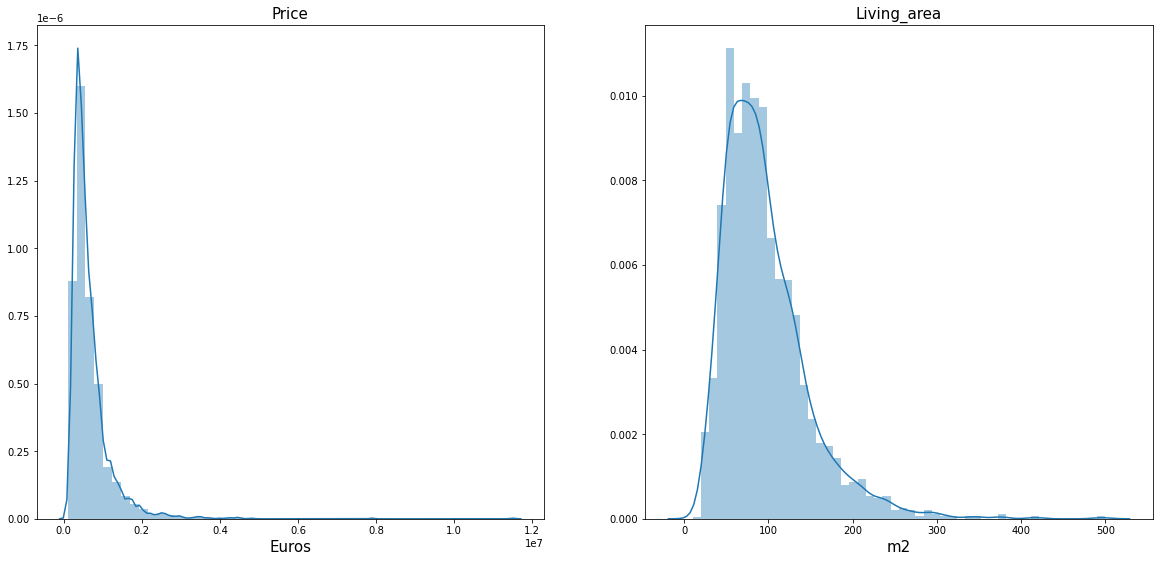

In [15]:
features = cdf.columns


plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.distplot(cdf['Price'])
plt.title(features[2], fontsize=15)
plt.xlabel('Euros', fontsize=15)

plt.subplot(2,2,2)
sns.distplot(cdf['Living_area'])
plt.title(features[0], fontsize=15)
plt.xlabel('m2', fontsize=15)

Since it is not good to have highly skewed features, we log-transform these two features:

In [16]:
cdf['log_price'] = np.log(cdf['Price'])
cdf['log_living_area'] = np.log(cdf['Living_area'])

In [17]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2844 entries, 0 to 2858
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Living_area      2844 non-null   int64  
 1   Rooms            2844 non-null   int64  
 2   Price            2844 non-null   int64  
 3   log_price        2844 non-null   float64
 4   log_living_area  2844 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 133.3 KB


We can see that the distributions of the transformed features are now roughly normal, we will keep the original features for the data exploration but discard them in the model.

Text(0.5, 0, 'log_m2')

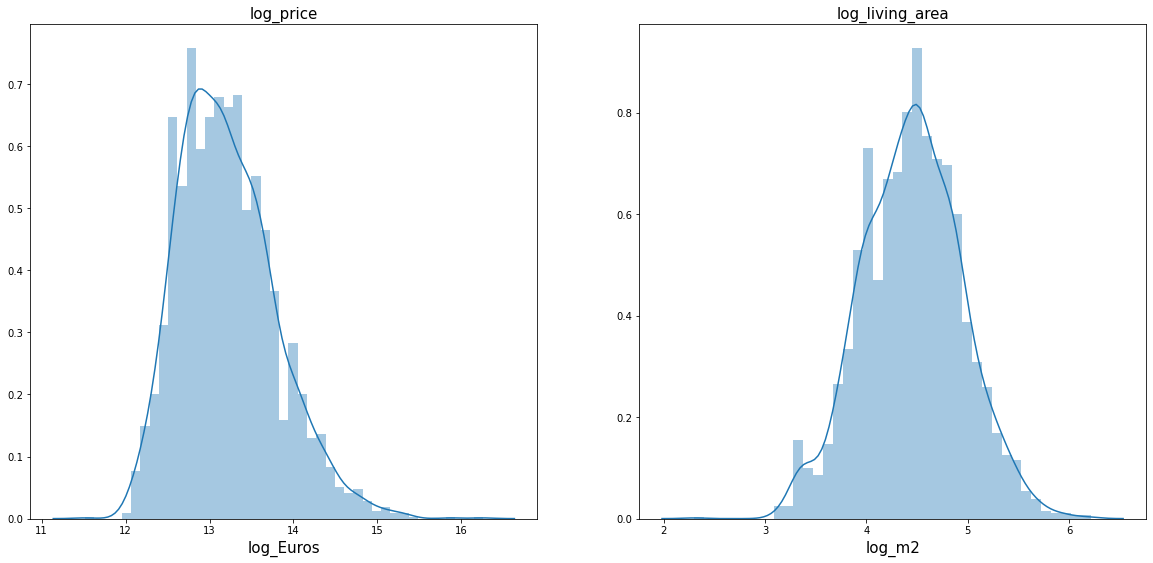

In [18]:
features = cdf.columns

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.distplot(cdf['log_price'])
plt.title(features[3], fontsize=15)
plt.xlabel('log_Euros', fontsize=15)

plt.subplot(2,2,2)
sns.distplot(cdf['log_living_area'])
plt.title(features[4], fontsize=15)
plt.xlabel('log_m2', fontsize=15)

Next we scatter plot the data. Since we want to predict the log price we plot the log price against the log living area and the log price against the number of rooms. As expected from previous research on this kind of problem, we can see that there is a roughly linear relationship between both: log living area and log price and number of rooms and log price. Also we notice that there are some outliers, both in the price, in the living area and in the number of rooms:

Text(0, 0.5, 'log_price')

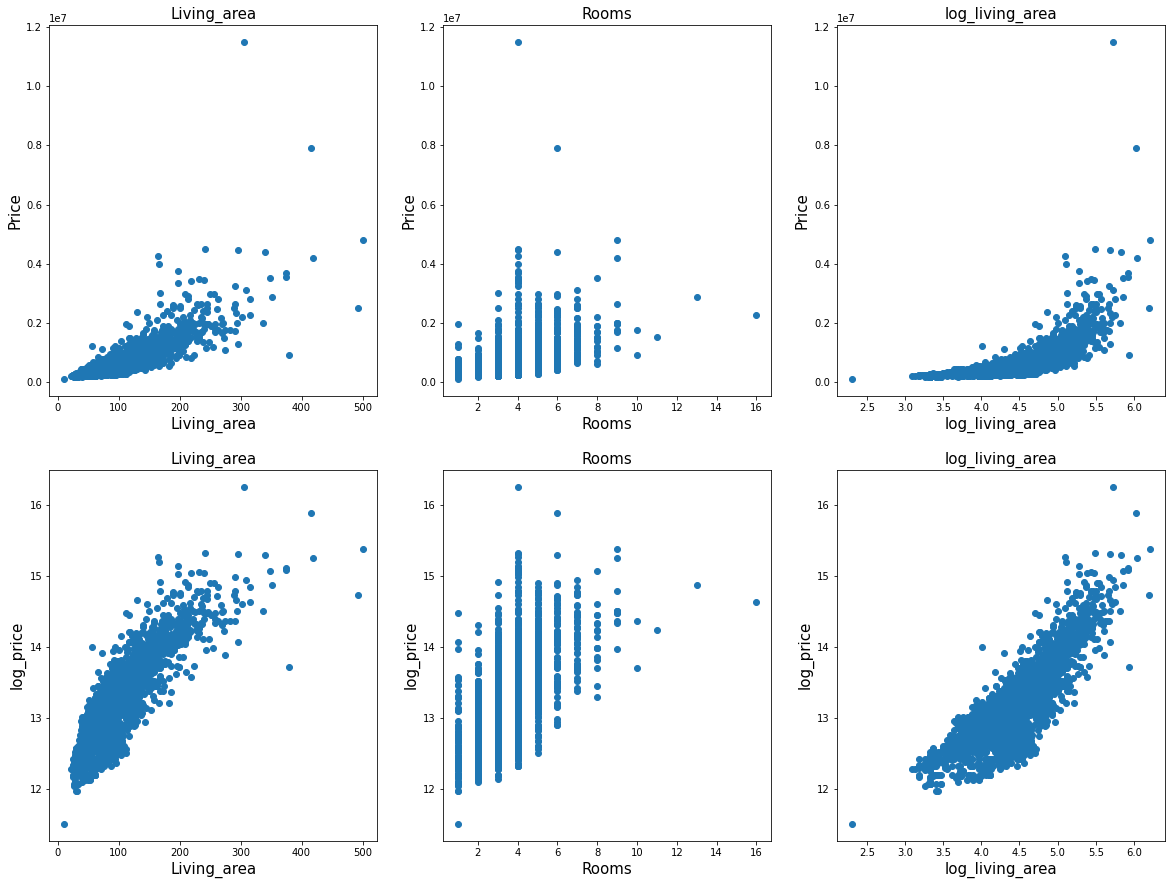

In [19]:
features = cdf.columns

plt.figure(figsize=(20,15))

plt.subplot(2,3,1)
plt.scatter(cdf['Living_area'], cdf['Price'])
plt.title(features[0], fontsize=15)
plt.xlabel(features[0], fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(2,3,2)
plt.scatter(cdf['Rooms'], cdf['Price'])
plt.title(features[1], fontsize=15)
plt.xlabel(features[1], fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(2,3,3)
plt.scatter(cdf['log_living_area'], cdf['Price'])
plt.title(features[4], fontsize=15)
plt.xlabel(features[4], fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(2,3,4)
plt.scatter(cdf['Living_area'], cdf['log_price'])
plt.title(features[0], fontsize=15)
plt.xlabel(features[0], fontsize=15)
plt.ylabel('log_price', fontsize=15)

plt.subplot(2,3,5)
plt.scatter(cdf['Rooms'], cdf['log_price'])
plt.title(features[1], fontsize=15)
plt.xlabel(features[1], fontsize=15)
plt.ylabel('log_price', fontsize=15)

plt.subplot(2,3,6)
plt.scatter(cdf['log_living_area'], cdf['log_price'])
plt.title(features[4], fontsize=15)
plt.xlabel(features[4], fontsize=15)
plt.ylabel('log_price', fontsize=15)

We further inspect the linear dependancy by making a seaborn regression plot:

Text(0, 0.5, 'log_price')

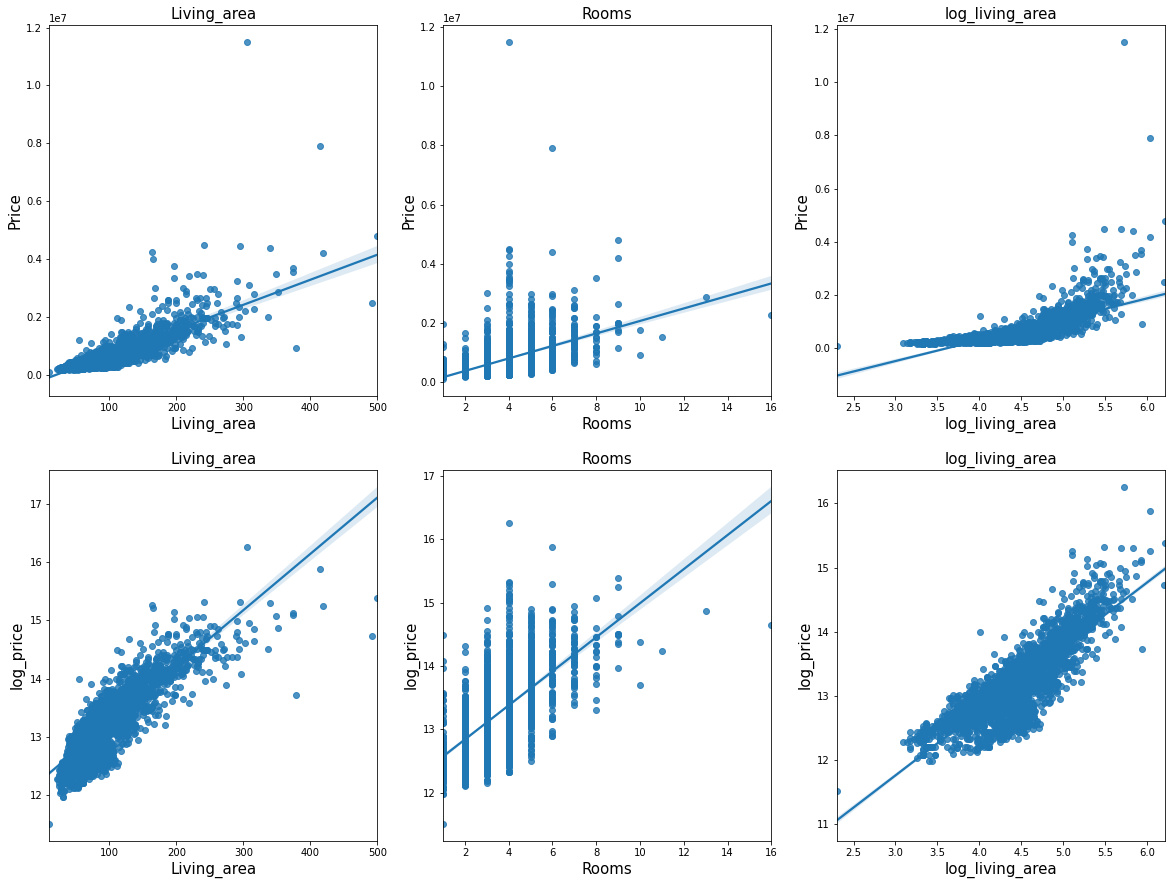

In [20]:
features = cdf.columns

plt.figure(figsize=(20,15))

plt.subplot(2,3,1)
sns.regplot(cdf['Living_area'], cdf['Price'])
plt.title(features[0], fontsize=15)
plt.xlabel(features[0], fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(2,3,2)
sns.regplot(cdf['Rooms'], cdf['Price'])
plt.title(features[1], fontsize=15)
plt.xlabel(features[1], fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(2,3,3)
sns.regplot(cdf['log_living_area'], cdf['Price'])
plt.title(features[4], fontsize=15)
plt.xlabel(features[4], fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(2,3,4)
sns.regplot(cdf['Living_area'], cdf['log_price'])
plt.title(features[0], fontsize=15)
plt.xlabel(features[0], fontsize=15)
plt.ylabel('log_price', fontsize=15)

plt.subplot(2,3,5)
sns.regplot(cdf['Rooms'], cdf['log_price'])
plt.title(features[1], fontsize=15)
plt.xlabel(features[1], fontsize=15)
plt.ylabel('log_price', fontsize=15)

plt.subplot(2,3,6)
sns.regplot(cdf['log_living_area'], cdf['log_price'])
plt.title(features[4], fontsize=15)
plt.xlabel(features[4], fontsize=15)
plt.ylabel('log_price', fontsize=15)

Since we want to run a linear regression we want to make sure there are no features mutually linearly dependent, so we make a regression plot of the number of rooms and the log living area. We can see that there seem to be some kind of linearly dependency between the two features:

Text(0, 0.5, 'log_Living_area')

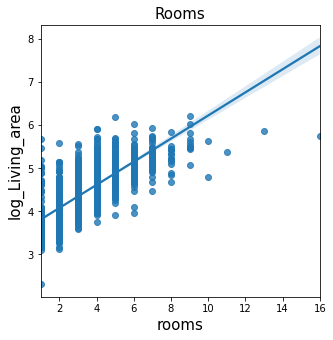

In [21]:
plt.figure(figsize=(5,5))

sns.regplot(x=cdf['Rooms'], y=cdf['log_living_area'], data=cdf);
plt.title('Rooms', fontsize=15)
plt.xlabel('rooms', fontsize=15)
plt.ylabel('log_Living_area', fontsize=15)

In [22]:
cdf = cdf.drop(cdf.columns[[0, 2]], axis=1)

This is further confirmed by examining the correlation coefficients, we can see that the highest correlation is between log living area and log price (0.85), rooms has also a good correlation with log price (0.62) but the two features have a notable correaltion between themselves (0.73). We expect that we will want to remove the rooms feature from the regression model:

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

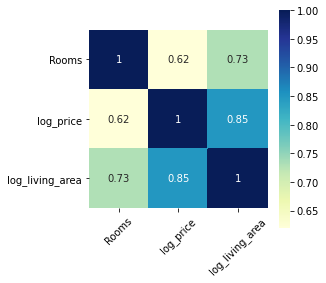

In [23]:
plt.figure(figsize=(4,4))
sns.heatmap(cdf.corr().round(2), square=True, cmap='YlGnBu', annot=True);
plt.xticks(rotation=45)
plt.yticks(rotation=0)

<h3>Methodology</h3>

We now built our linear regression model, since rooms have a high correlation with price we built three models, one with each of the two features and one with both to compare the results. The first step is to split the data into train and test set:

In [24]:
X = cdf[['log_living_area','Rooms']]

y = cdf['log_price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2275, 2) (2275,)
Test set: (569, 2) (569,)


Next we built and fit the three models:

In [25]:
from sklearn import linear_model
regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
regr3 = linear_model.LinearRegression()
regr1.fit(X_train[['log_living_area']], y_train)
regr2.fit(X_train[['Rooms']], y_train)
regr3.fit(X_train, y_train)

LinearRegression()

And we compare their mean squared errors and r2 scores, we can see that, as expected, the regression on rooms feature alone performs badly, also there is no improvement in including this feature next to the log living area feature. The best model is indeed the one on the log living area feature only, in what follows we will exclude the feature rooms from the models:

In [26]:
y_pred1 = regr1.predict(X_test[['log_living_area']])
y_pred2 = regr2.predict(X_test[['Rooms']])
y_pred3 = regr3.predict(X_test)

from sklearn.metrics import r2_score

print('Mean squared error model 1: %.4f' % np.mean((y_pred1 - y_test) ** 2))

print('r2 score model 1 : %.4f' % r2_score(y_test,y_pred1))

print('Mean squared error model 2: %.4f' % np.mean((y_pred2 - y_test) ** 2))

print('r2 score model 2: %.4f' % r2_score(y_test,y_pred2))

print('Mean squared error model 3: %.4f' % np.mean((y_pred3 - y_test) ** 2))

print('r2 score model 3: %.4f' % r2_score(y_test,y_pred3))

Mean squared error model 1: 0.0889
r2 score model 1 : 0.7294
Mean squared error model 2: 0.1904
r2 score model 2: 0.4205
Mean squared error model 3: 0.0889
r2 score model 3: 0.7293


We drop the rooms feature from the dataframe:

In [27]:
cdf = cdf.drop(cdf.columns[[0]], axis=1)

In [28]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2844 entries, 0 to 2858
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   log_price        2844 non-null   float64
 1   log_living_area  2844 non-null   float64
dtypes: float64(2)
memory usage: 66.7 KB


For completeness we extract the regression coefficient of the first (and best) model:

In [29]:
print ('Coefficients: ', np.round(regr1.coef_,3))

Coefficients:  [0.996]


And we evaluate the selected model with more metrics:

In [30]:
from sklearn import metrics
print('Mean Absolute Error:%.2f' % metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:%.2f' % metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:%.2f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

Mean Absolute Error:0.22
Mean Squared Error:0.09
Root Mean Squared Error:0.30


Lastly we draw a predicted versus actual prices plot, we can see that the model performs very good on roughly the first half of the range but, as commonly seen, fails to predict properly the price of the outliers:

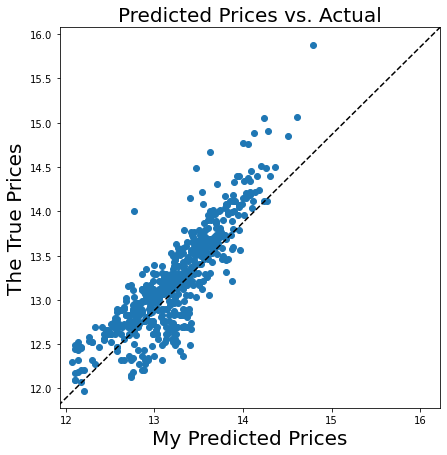

In [31]:
plt.figure(figsize=(7,7))

plt.scatter(y_pred1, y_test)
plt.axis('square')
xmin, xmax, ymin, ymax = plt.axis()

plt.plot([0, xmax], [0, ymax], '--k')

plt.ylabel('The True Prices', fontsize=20);

plt.xlabel('My Predicted Prices', fontsize=20);
plt.title("Predicted Prices vs. Actual", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

<h3>Second part of the project</h3>

In the second part of the project we focus on gathering the additional data from the Foursquare API and then  we add it to the housing dataseta of the previous part trying to improve the performance of the linear regression. We will follow along the steps of the previous project for the Forsquare data.

We import the necessary libraries:

In [32]:
import random

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import json

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

/Users/HomeJahzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


Since we will want to inspect the dataframe we make sure all the rows and columns are displayed:

In [33]:
pd.set_option('display.max_colwidth', None)

We need to use the coordinates of the approximate center of each postcode area, since they are only 72 areas we have gathered the coordinates manually from google maps instead of using the google API, and saved them in a cvs file:

In [34]:
df_postcodes_coor = pd.read_csv("Geospatial_Coordinates.csv") 
df_postcodes_coor

,Postal Code,Latitude,Longitude
0,1011,52.372203,4.905295
1,1012,52.374560,4.895144
2,1013,52.393093,4.875940
3,1014,52.392011,4.855188
4,1015,52.378275,4.885721
5,1016,52.370875,4.881798
6,1017,52.362956,4.892149
7,1018,52.367603,4.917927
8,1019,52.372298,4.938068
9,1021,52.384772,4.917408


Next we insert manually Amsterdam's coordinates:

In [35]:
latitude = 52.3676
longitude = 4.9041

We plot a map of amsterdam with the use of folium library:

In [36]:
# create map of Amsterdam using latitude and longitude values
map_Amsterdam = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, postcode in zip(df_postcodes_coor['Latitude'], df_postcodes_coor['Longitude'], df_postcodes_coor['Postal Code']):
    label = '{}'.format(postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Amsterdam)  
    
map_Amsterdam

Insert Foursquare's credentials:

In [37]:
CLIENT_ID = 'WHD4RCWNEGKIOFXU3VKL215GKMF3DQ2OTLG5JQKTMD03K12Z' # your Foursquare ID
CLIENT_SECRET = 'RLXTVROET1ME1VOJIBKNUDWULALDTNMCH4OSIHNDDJ2ZKIGI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 150 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WHD4RCWNEGKIOFXU3VKL215GKMF3DQ2OTLG5JQKTMD03K12Z
CLIENT_SECRET:RLXTVROET1ME1VOJIBKNUDWULALDTNMCH4OSIHNDDJ2ZKIGI


The next two cells are the functions provided by the course to extract the venues near each coordinate point:

In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Postal code area Latitude', 
                  'Postal code area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We extract the venues of amsterdam per postcode area with the use of the two previous functions:

In [40]:
Amsterdam_venues = getNearbyVenues(names=df_postcodes_coor['Postal Code'],
                                   latitudes=df_postcodes_coor['Latitude'],
                                   longitudes=df_postcodes_coor['Longitude']
                                  )

1011
1012
1013
1014
1015
1016
1017
1018
1019
1021
1022
1023
1024
1025
1026
1027
1028
1031
1032
1033
1034
1035
1036
1037
1041
1042
1043
1044
1045
1046
1047
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1071
1072
1073
1074
1075
1076
1077
1078
1079
1081
1082
1083
1086
1087
1088
1091
1092
1093
1094
1095
1096
1097
1098


We have extracted this number of venues:

In [41]:
print(Amsterdam_venues.shape)

(2255, 7)


In [42]:
Amsterdam_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255 entries, 0 to 2254
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Postal Code                 2255 non-null   int64  
 1   Postal code area Latitude   2255 non-null   float64
 2   Postal code area Longitude  2255 non-null   float64
 3   Venue                       2255 non-null   object 
 4   Venue Latitude              2255 non-null   float64
 5   Venue Longitude             2255 non-null   float64
 6   Venue Category              2255 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 123.4+ KB


With the following two cells we plot the number of venues per post code area in descending order, we can see that for 6 areas we have attained the maximum number of venues of 100 allowed by the API, also in this case we see we have some kind of power law shape:

In [43]:
dff = Amsterdam_venues.groupby('Postal Code').count()
dff.reset_index(level=0, inplace=True)
AA = dff[['Postal Code','Venue']]

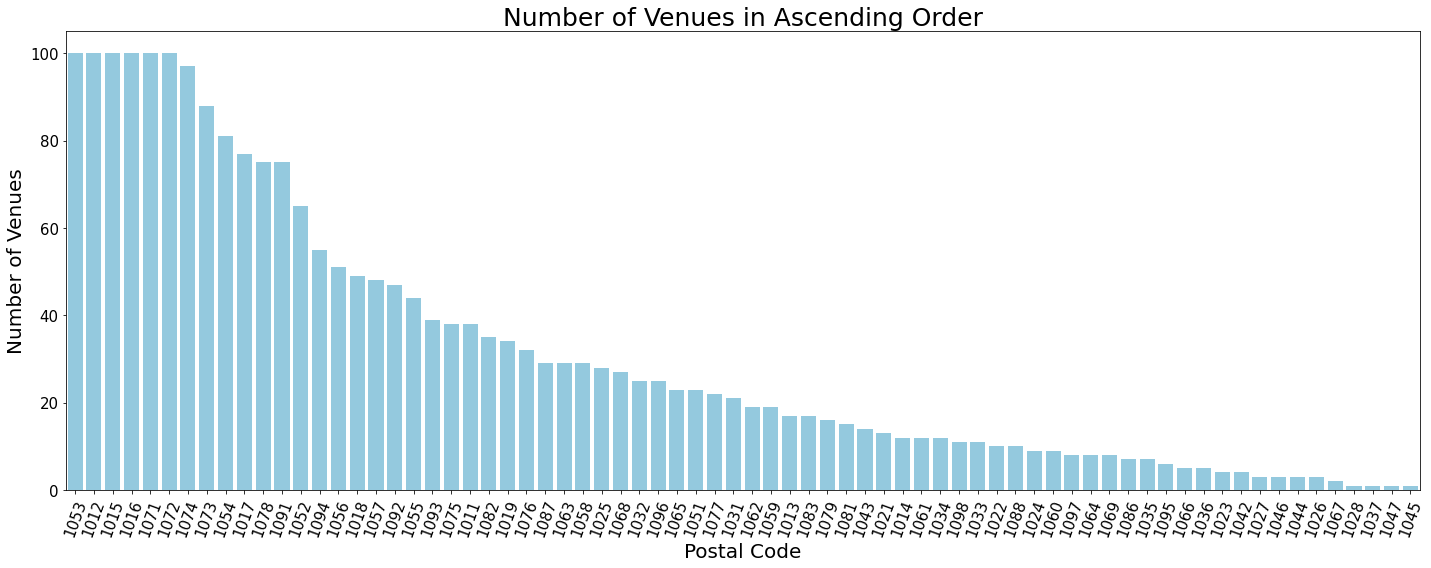

In [44]:
dff_sorted = dff.sort_values(['Venue'],ascending=False).reset_index(drop=True)

plt.figure(figsize=(20,8))

sns.barplot(x='Postal Code', y='Venue', data=dff_sorted, order = dff_sorted['Postal Code'], color='skyblue')

plt.xticks(rotation=70)
plt.xlabel("Postal Code", size=20)
plt.ylabel("Number of Venues", size=20)
plt.title("Number of Venues in Ascending Order", size=25)
plt.tight_layout()

We see how many categories there are:

In [45]:
print('There are {} uniques categories.'.format(len(Amsterdam_venues['Venue Category'].unique())))

There are 280 uniques categories.


Next we one-hot-encode the categories in order to prepare the data for the clustering algorithm:

In [46]:
# one hot encoding
Amsterdam_onehot = pd.get_dummies(Amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
Amsterdam_onehot['Postal Code'] = Amsterdam_venues['Postal Code'] 

# move neighbourhood column to the first column
fixed_columns = [Amsterdam_onehot.columns[-1]] + list(Amsterdam_onehot.columns[:-1])
Amsterdam_onehot = Amsterdam_onehot[fixed_columns]

Amsterdam_onehot.head()

,Postal Code,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lebanese Restaurant,Lingerie Store,Liquor Store,Luggage Store,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nail Salon,Neighborhood,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,VR Cafe,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [47]:
Amsterdam_onehot.shape

(2255, 281)

In [48]:
Amsterdam_grouped = Amsterdam_onehot.groupby('Postal Code').mean().reset_index()

In [49]:
Amsterdam_grouped.shape

(72, 281)

In the next cells we exctract the 10 top venues and their frequencies to prepare the data for the clustering algorithm:

In [50]:
num_top_venues = 10

for code in Amsterdam_grouped['Postal Code']:
    print("----"+str(code)+"----")
    temp = Amsterdam_grouped[Amsterdam_grouped['Postal Code'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1011----
                      venue  freq
0                    Hostel  0.08
1                       Bar  0.08
2              Cocktail Bar  0.05
3                     Hotel  0.05
4               Coffee Shop  0.05
5             Grocery Store  0.05
6  Mediterranean Restaurant  0.05
7            Breakfast Spot  0.03
8                   Gay Bar  0.03
9                 Gastropub  0.03


----1012----
                  venue  freq
0           Coffee Shop  0.06
1                 Hotel  0.06
2                   Bar  0.06
3  Marijuana Dispensary  0.04
4                  Café  0.04
5            Restaurant  0.04
6                   Pub  0.04
7     French Restaurant  0.03
8              Beer Bar  0.03
9            Steakhouse  0.02


----1013----
                           venue  freq
0                     Restaurant  0.18
1                          Hotel  0.12
2                        Theater  0.12
3                           Pool  0.06
4                    Snack Place  0.06
5                  

                           venue  freq
0                           Café  0.06
1                            Bar  0.05
2           Ethiopian Restaurant  0.05
3                    Coffee Shop  0.04
4             Italian Restaurant  0.04
5            Moroccan Restaurant  0.04
6  Vegetarian / Vegan Restaurant  0.04
7               Tapas Restaurant  0.02
8                     Restaurant  0.02
9                         Bakery  0.02


----1055----
                           venue  freq
0                            Bar  0.07
1                    Supermarket  0.07
2  Vegetarian / Vegan Restaurant  0.07
3                    Coffee Shop  0.05
4                     Playground  0.05
5                         Bakery  0.05
6                           Park  0.05
7          Indonesian Restaurant  0.05
8                     Food Court  0.02
9              Food & Drink Shop  0.02


----1056----
                       venue  freq
0                        Bar  0.06
1         Chinese Restaurant  0.04
2      

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Postcode_venues_sorted = pd.DataFrame(columns=columns)
Postcode_venues_sorted['Postal Code'] = Amsterdam_grouped['Postal Code']

for ind in np.arange(Amsterdam_grouped.shape[0]):
    Postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Amsterdam_grouped.iloc[ind, :], num_top_venues)

# Postcode_venues_sorted.head()

We are now ready to run kmeans clustering algorithm. In order to choose the number of clusters we first plot the elbow curve:  

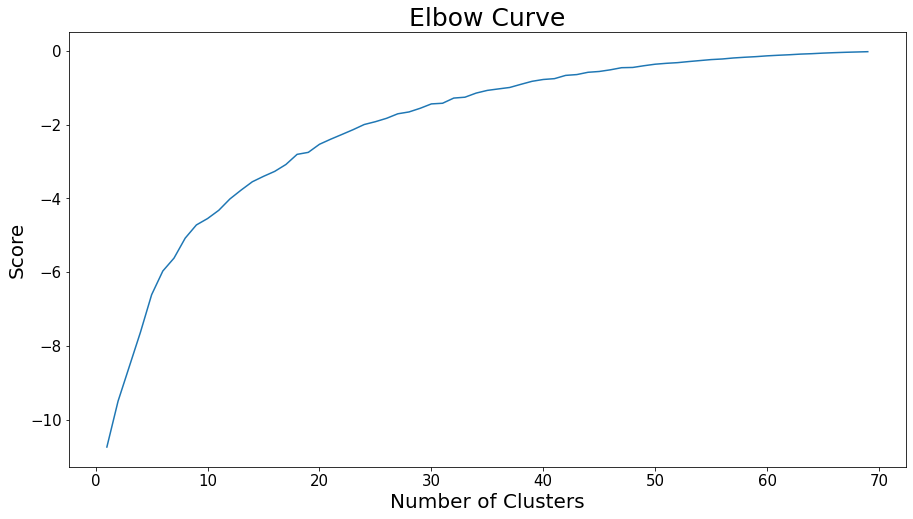

In [53]:
Amsterdam_grouped_clustering = Amsterdam_grouped.drop('Postal Code', 1)

plt.figure(figsize=(15,8))


Nc = range(1, 70)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(Amsterdam_grouped_clustering).score(Amsterdam_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters', size=20)
plt.ylabel('Score', size=20)
plt.title('Elbow Curve', size=25)
plt.show()

We can see that the elbow curve does not have a clear cusp point, this doesn't mean that the data can not be clustered, it means that we need to be more careful in choosing the right number of clusters. We will at first make an attempt with 10 clusters and see if our linear regression model improves with this number of clusters, after that we will further explore all the range of cluster numbers:

In [54]:
# run k-means clustering
kclusters = 10
kmeans10 = KMeans(n_clusters=kclusters, random_state=0).fit(Amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
A = kmeans10.labels_[0:]

print(sorted(A))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 8, 9]


Next we add the cluster labels to the dataframe:

In [55]:
### add clustering labels
#Postcode_venues_sorted.drop('Cluster Labels', axis='columns', inplace=True) # UNCOMMENT THIS LINE IF YOU WANT TO RUN THE CLUSTERING AGAIN!
Postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans10.labels_) 

Amsterdam_merged = df_postcodes_coor

Amsterdam_merged = Amsterdam_merged.join(Postcode_venues_sorted.set_index('Postal Code'), on='Postal Code')

Amsterdam_merged.head() # check the last columns!

,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1011,52.372203,4.905295,0.0,Hostel,Bar,Hotel,Cocktail Bar,Grocery Store,Mediterranean Restaurant,Coffee Shop,Bike Rental / Bike Share,Breakfast Spot,Butcher
1,1012,52.374560,4.895144,0.0,Hotel,Coffee Shop,Bar,Restaurant,Pub,Marijuana Dispensary,Café,Beer Bar,French Restaurant,Museum
2,1013,52.393093,4.875940,0.0,Restaurant,Hotel,Theater,Turkish Restaurant,Pool,Museum,Modern European Restaurant,Snack Place,Supermarket,Bagel Shop
3,1014,52.392011,4.855188,0.0,Soccer Field,Hotel,Thrift / Vintage Store,Nightclub,Bus Stop,Dog Run,Music Venue,Climbing Gym,Café,Farm
4,1015,52.378275,4.885721,0.0,Bar,Café,Italian Restaurant,Sandwich Place,Marijuana Dispensary,Hotel,Cosmetics Shop,Organic Grocery,Dessert Shop,Coffee Shop


We can see that some clusters are NaN, we will get rid of it later:

In [56]:
Amsterdam_merged['Cluster Labels'].unique()

array([ 0.,  7.,  6.,  1.,  8.,  2., nan,  9.,  3.,  5.,  4.])

We then merge the two dataframes based on postal code:

In [57]:
BB = Amsterdam_merged[['Postal Code','Cluster Labels']]

Merge1 = pd.merge(AA, BB, on='Postal Code')

We noticed that we got NaN for some cluster labels, they are just a few, so I decided to just remove these rows:

In [58]:
Amsterdam_merged.dropna(subset = ["Cluster Labels"], inplace=True)

Because of the NaN values, the cluster labels were casted into floats, so we cast them back into integers:

In [59]:
Amsterdam_merged['Cluster Labels'] = Amsterdam_merged['Cluster Labels'].astype(int)

In [60]:
Amsterdam_merged['Cluster Labels'].unique()

array([0, 7, 6, 1, 8, 2, 9, 3, 5, 4])

Lastly, we display the map with the post code areas belonging to the different clusters:

In [61]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Amsterdam_merged['Latitude'], Amsterdam_merged['Longitude'], Amsterdam_merged['Postal Code'], Amsterdam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can see that the clustering algorithm has done a great job in differentiating between areas in the center and areas in the outskirts of town, this is noticeable because the clustering is based only on the venues data and not on geographical data.

In what follows we finally merge the two datasets and see if we can improve our linear regression housing price prediction by adding the Foursquare data and the cluster labels. Clearly we do not expect to be able to use the cluster labels directly in the regression as the actual cluster label numbers are assigned randomly by the algorithm.

In the next cells we rearrange the data and make some renaming:

In [62]:
Merge1_new = Merge1.rename(columns={'Postal Code': 'Postcode'})                                    

In [63]:
Merge2 = cdf
Merge2['Postcode'] = df_houses['Postcode']

In [64]:
Merge2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2844 entries, 0 to 2858
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   log_price        2844 non-null   float64
 1   log_living_area  2844 non-null   float64
 2   Postcode         2844 non-null   object 
dtypes: float64(2), object(1)
memory usage: 88.9+ KB


In [65]:
Merge2[["Postcode"]] = Merge2[["Postcode"]].apply(pd.to_numeric)

In [66]:
Merge1_new['Cluster Labels'].unique()

array([0., 7., 6., 1., 8., 2., 9., 3., 5., 4.])

In [67]:
Merge1_new

,Postcode,Venue,Cluster Labels
0,1011,38,0.0
1,1012,100,0.0
2,1013,17,0.0
3,1014,12,0.0
4,1015,100,0.0
5,1016,100,0.0
6,1017,77,0.0
7,1018,49,0.0
8,1019,34,0.0
9,1021,13,0.0


Finally we merge the two datasets with Postcode as key:

In [68]:
Amsterdam_combined = pd.merge(Merge1_new, Merge2, on='Postcode')

We can see that not all label are now present (probably because of lack of houses in some areas):

In [69]:
Amsterdam_combined['Cluster Labels'].unique()

array([0., 7., 8., 4., 6.])

So we have a dataframe, for each house we have: Postcode, number of venues in that postcode area, cluster label of the postcode area, log living area and log price:

In [70]:
Amsterdam_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733 entries, 0 to 2732
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Postcode         2733 non-null   int64  
 1   Venue            2733 non-null   int64  
 2   Cluster Labels   2733 non-null   float64
 3   log_price        2733 non-null   float64
 4   log_living_area  2733 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 128.1 KB


We then get rid of the postcode feature:

In [71]:
Amsterdam_combined = Amsterdam_combined.drop(Amsterdam_combined.columns[[0]], axis=1)

In [72]:
features = Amsterdam_combined.columns
features

Index(['Venue', 'Cluster Labels', 'log_price', 'log_living_area'], dtype='object')

In [73]:
Amsterdam_combined.shape

(2733, 4)

And remove duplicates:

In [74]:
Amsterdam_combined.duplicated().sum()

116

In [75]:
Amsterdam_combined = Amsterdam_combined.drop_duplicates()

In [76]:
Amsterdam_combined.shape

(2617, 4)

In [77]:
features = Amsterdam_combined.columns
features

Index(['Venue', 'Cluster Labels', 'log_price', 'log_living_area'], dtype='object')

Text(0.5, 1.0, 'Boxplot grouped by cluster')

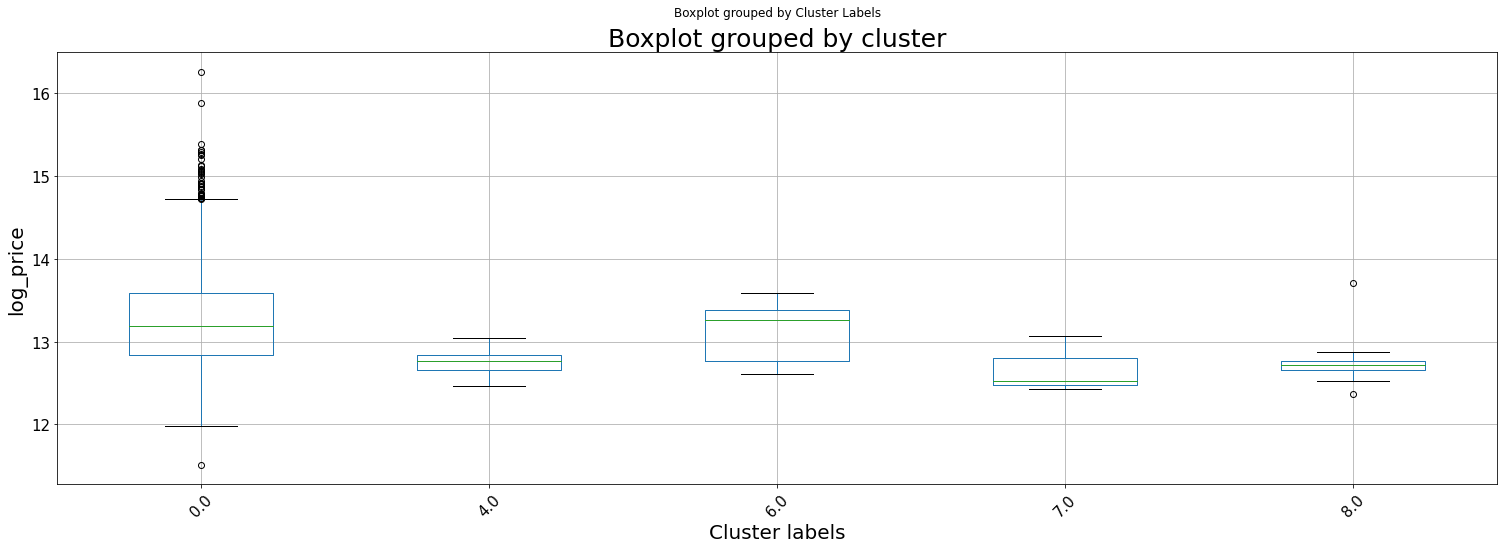

In [78]:
Amsterdam_combined[['log_price','Cluster Labels']].boxplot(by='Cluster Labels', figsize=[25,8], rot=45)
plt.ylabel('log_price', size=20)
plt.xlabel('Cluster labels', size=20)
plt.title('Boxplot grouped by cluster', size=25)

We explore the data with a regression plot:

Text(0, 0.5, 'log_price')

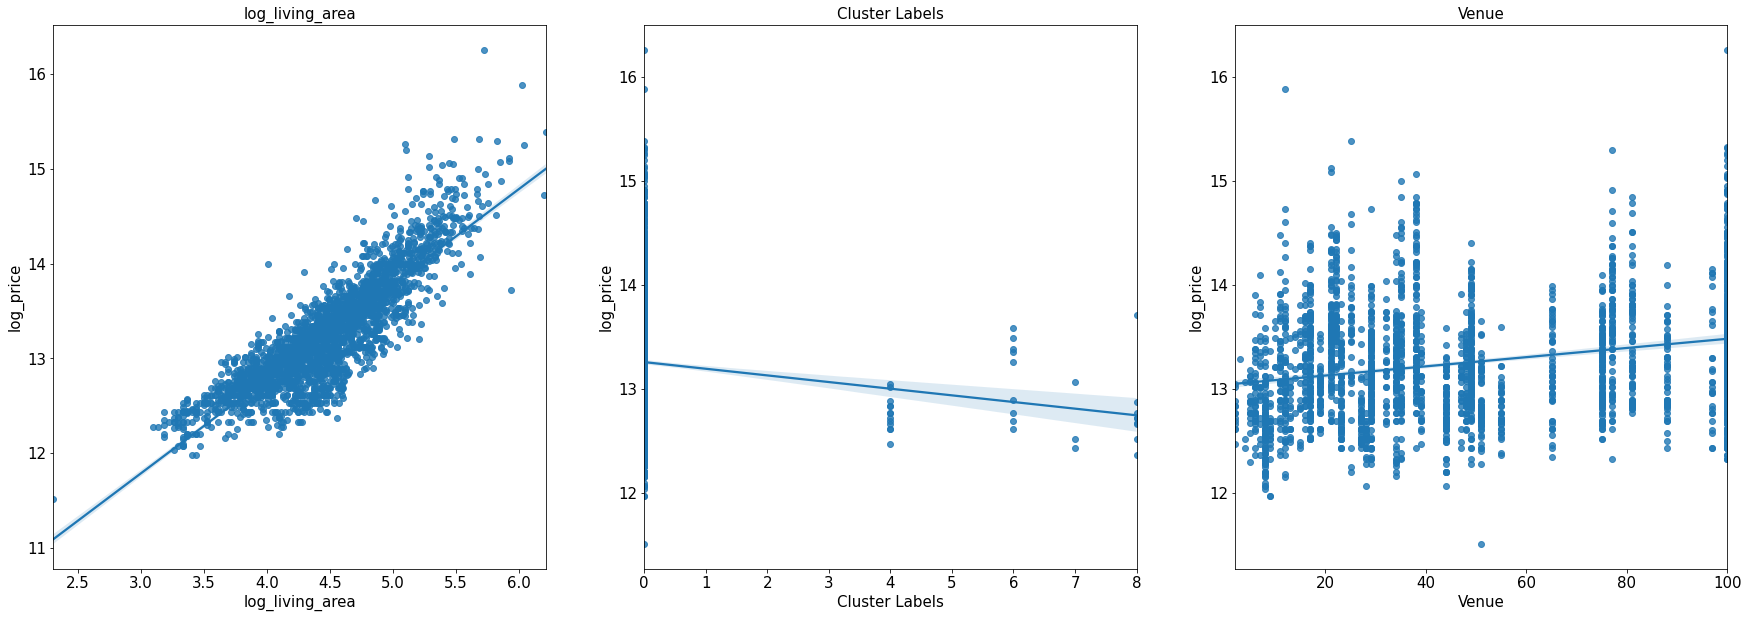

In [79]:
features = Amsterdam_combined.columns

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
sns.regplot(Amsterdam_combined['log_living_area'], Amsterdam_combined['log_price'])
plt.title(features[3], fontsize=15)
plt.xlabel(features[3], fontsize=15)
plt.ylabel('log_price', fontsize=15)

plt.subplot(1,3,2)
sns.regplot(Amsterdam_combined['Cluster Labels'], Amsterdam_combined['log_price'])
plt.title(features[1], fontsize=15)
plt.xlabel(features[1], fontsize=15)
plt.ylabel('log_price', fontsize=15)

plt.subplot(1,3,3)
sns.regplot(Amsterdam_combined['Venue'], Amsterdam_combined['log_price'])
plt.title(features[0], fontsize=15)
plt.xlabel(features[0], fontsize=15)
plt.ylabel('log_price', fontsize=15)

And we inspect the correlation coefficients, as expected cluster labels have little correlation with the log price while the number of venues has a better score. We would have expected to have a higher correlation between the number of venues and the price. We remind that the number of venues comes solely from the Foursquare data and not from the clustering algorithm:

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

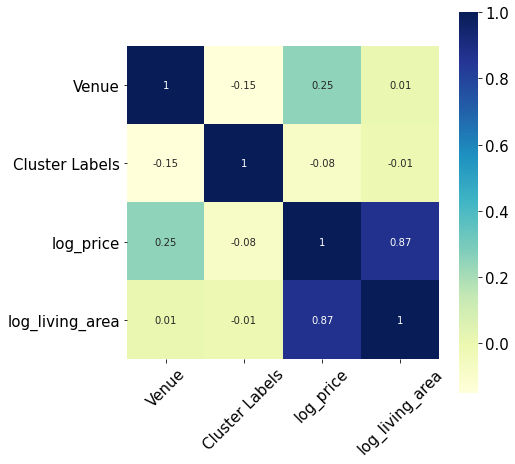

In [80]:
plt.figure(figsize=(7,7))
sns.heatmap(Amsterdam_combined.corr().round(2), square=True, cmap='YlGnBu', annot=True);
plt.xticks(rotation=45)
plt.yticks(rotation=0)

We make one copy of the combined data with 10 clusters:

In [81]:
Amsterdam_combined3 = Amsterdam_combined

Then we run the linear regressions with the combined data:

In [82]:
X = Amsterdam_combined[['log_living_area','Venue','Cluster Labels']]

y = Amsterdam_combined['log_price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2093, 3) (2093,)
Test set: (524, 3) (524,)


In [83]:
features

Index(['Venue', 'Cluster Labels', 'log_price', 'log_living_area'], dtype='object')

In [84]:
from sklearn import linear_model
regr0 = linear_model.LinearRegression()
regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
regr3 = linear_model.LinearRegression()
regr4 = linear_model.LinearRegression()
regr5 = linear_model.LinearRegression()

regr0.fit(X_train[['log_living_area']], y_train)
regr1.fit(X_train[['log_living_area','Venue']], y_train)
regr2.fit(X_train[['log_living_area','Cluster Labels']], y_train)
regr3.fit(X_train[['Cluster Labels']], y_train)
regr4.fit(X_train[['Venue']], y_train)
regr5.fit(X_train, y_train)

LinearRegression()

We can see that we have a significant improvement in the r2 score when we make the regression on the features living area and number of venues only, from about 0.74 to about 0.80, while, as expected, there is little improvement when further adding the cluster labels:

In [85]:
y_pred0 = regr0.predict(X_test[['log_living_area']])
y_pred1 = regr1.predict(X_test[['log_living_area','Venue']])
y_pred2 = regr2.predict(X_test[['log_living_area','Cluster Labels']])
y_pred3 = regr3.predict(X_test[['Cluster Labels']])
y_pred4 = regr4.predict(X_test[['Venue']])
y_pred5 = regr5.predict(X_test)

from sklearn.metrics import r2_score

print('r2 score model 0 : %.4f' % r2_score(y_test,y_pred0))
print('Residual sum of squares model 1: %.4f' % np.mean((y_pred0 - y_test) ** 2))
print('')

print('r2 score model 1 : %.4f' % r2_score(y_test,y_pred1))
print('Residual sum of squares model 1: %.4f' % np.mean((y_pred1 - y_test) ** 2))
print('')

print('r2 score model 2: %.4f' % r2_score(y_test,y_pred2))
print('Residual sum of squares model 2: %.4f' % np.mean((y_pred2 - y_test) ** 2))
print('')

print('r2 score model 3: %.4f' % r2_score(y_test,y_pred3))
print('Residual sum of squares model 3: %.4f' % np.mean((y_pred3 - y_test) ** 2))
print('')

print('r2 score model 4: %.4f' % r2_score(y_test,y_pred4))
print('Residual sum of squares model 4: %.4f' % np.mean((y_pred4 - y_test) ** 2))
print('')

print('r2 score model 5: %.4f' % r2_score(y_test,y_pred5))
print('Residual sum of squares model 5: %.4f' % np.mean((y_pred5 - y_test) ** 2))
print('')

r2 score model 0 : 0.7560
Residual sum of squares model 1: 0.0803

r2 score model 1 : 0.8149
Residual sum of squares model 1: 0.0609

r2 score model 2: 0.7608
Residual sum of squares model 2: 0.0787

r2 score model 3: -0.0043
Residual sum of squares model 3: 0.3306

r2 score model 4: 0.0448
Residual sum of squares model 4: 0.3144

r2 score model 5: 0.8161
Residual sum of squares model 5: 0.0605



For completeness we check the p values and statistical significance of the features in the regression, we can see that the p values are all very small but they also indicate that the features to be selected are definitely living area and venue:

In [86]:
import statsmodels.api as sm
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

log_living_area    0.000000e+00
Venue              4.560505e-38
Cluster Labels     2.539804e-01
Name: P>|t|, dtype: float64

We have made a regression for the combined data in the case of 10 clusters, we want now to explore the dependancy of the r2 score and RMSEs on the number of clusters. We can see that as expected there is almost no variation in the r2 scores and error with respect to the number of clusters:

In [87]:
max_clusters = 70

r2_scores = []
RMSEs = []

for kclusters in range(1,max_clusters+1):
    
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Amsterdam_grouped_clustering)
    A = kmeans.labels_[0:]
    
    Postcode_venues_sorted.drop('Cluster Labels', axis='columns', inplace=True)
    Postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    
    Amsterdam_merged = df_postcodes_coor
    Amsterdam_merged = Amsterdam_merged.join(Postcode_venues_sorted.set_index('Postal Code'), on='Postal Code')
    
    BB = Amsterdam_merged[['Postal Code','Cluster Labels']]
    
    Merge1 = pd.merge(AA, BB, on='Postal Code')
    
    Amsterdam_merged.dropna(subset = ["Cluster Labels"], inplace=True)
    
    Amsterdam_merged['Cluster Labels'] = Amsterdam_merged['Cluster Labels'].astype(int)
    
    Merge1_new = Merge1.rename(columns={'Postal Code': 'Postcode'})
    
    Merge2 = cdf
    Merge2[["Postcode"]] = Merge2[["Postcode"]].apply(pd.to_numeric)
    
    Amsterdam_combined = pd.merge(Merge1_new, Merge2, on='Postcode')
    Amsterdam_combined = Amsterdam_combined.drop_duplicates()
    
    X = Amsterdam_combined[['log_living_area','Venue','Cluster Labels']]
    y = Amsterdam_combined['log_price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    
    regr11 = linear_model.LinearRegression()
    regr11.fit(X_train, y_train)
    y_pred11 = regr11.predict(X_test)
    
    r2_scores.append(r2_score(y_test,y_pred11))
    RMSEs.append(np.mean((y_pred11 - y_test) ** 2))

In [88]:
np.max(r2_scores)-np.min(r2_scores)

0.023331992167179183

Text(0.5, 0, 'Number of clusters')

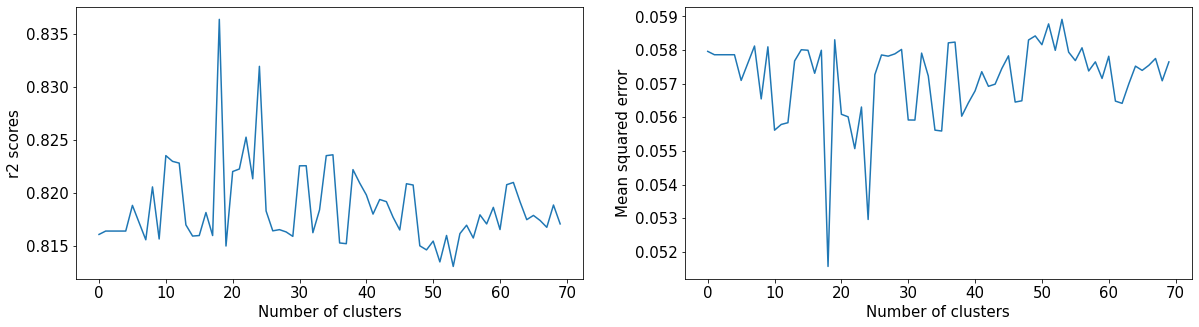

In [89]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(r2_scores)
plt.ylabel('r2 scores', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

plt.subplot(1,2,2)
plt.plot(RMSEs)
plt.ylabel('Mean squared error', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

In [90]:
np.max(RMSEs)-np.min(RMSEs)

0.007352021203713796

We try now a different approach and try to use the cluster labels in a different way: we run the linear regression on the bigger cluster only, we can expect to be able to make a better estimate at the expense of removing some data and use the data in that specific cluster only. We will see that this will increase the r2 score and given that the number of clusters is not too high we will not have to discard too much data. We will try this in the case of 10 clusters first, and then we explore all the range of clusters:

In [91]:
Amsterdam_combined3.shape

(2617, 4)

We explore the number of entries per cluster (we are in the case of 10 clusters which were reduced to 5). We can see that most of houses are assigned to one of the clusters while the other clusters have much less entries:

In [92]:
n_by_cluster = Amsterdam_combined3.groupby("Cluster Labels")["log_price"].count()

In [93]:
n_by_cluster

Cluster Labels
0.0    2583
4.0      13
6.0       9
7.0       3
8.0       9
Name: log_price, dtype: int64

We extract the label of the biggest cluster:

In [94]:
import statistics 
from statistics import mode 

A = Amsterdam_combined3['Cluster Labels']

main_label = mode(A)
main_label

0.0

And exctract the biggest cluter from the data:

In [95]:
cluster0 = Amsterdam_combined3[Amsterdam_combined3['Cluster Labels'] == main_label]

In [96]:
cluster0 = cluster0.drop('Cluster Labels',1)

In [97]:
cluster0.shape

(2583, 3)

In [98]:
cluster0.duplicated().sum()

0

We inspect the correlation coefficients:

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

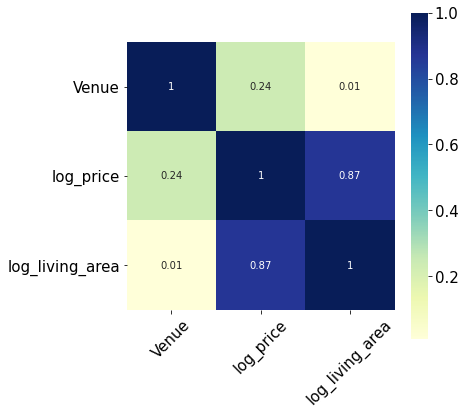

In [99]:
plt.figure(figsize=(6,6))
sns.heatmap(cluster0.corr().round(2), square=True, cmap='YlGnBu', annot=True);
plt.xticks(rotation=45)
plt.yticks(rotation=0)

And run the linear regression on the main cluster:

In [100]:
X = cluster0[['log_living_area','Venue']]

y = cluster0['log_price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2066, 2) (2066,)
Test set: (517, 2) (517,)


In [101]:
from sklearn import linear_model

regr3 = linear_model.LinearRegression()
regr4 = linear_model.LinearRegression()

regr3.fit(X_train[['log_living_area']], y_train)
regr4.fit(X_train[['log_living_area','Venue']], y_train)

LinearRegression()

We can see that the r2 score of the regression on the living area feature alone has improved from around 0.76 to around 0.77, however if we add the number of venues feature we have a better r2 score compared to the first attempt we made, the improvement is approximately 0.02, from about 0.80 to 0.82:

In [102]:
y_pred3 = regr3.predict(X_test[['log_living_area']])
y_pred4 = regr4.predict(X_test[['log_living_area','Venue']])

from sklearn.metrics import r2_score

print('r2 score model 3: %.4f' % r2_score(y_test,y_pred3))
print('Residual sum of squares model 3: %.4f' % np.mean((y_pred3 - y_test) ** 2))
print('')

print('r2 score model 4: %.4f' % r2_score(y_test,y_pred4))
print('Residual sum of squares model 4: %.4f' % np.mean((y_pred4 - y_test) ** 2))
print('')

r2 score model 3: 0.7691
Residual sum of squares model 3: 0.0830

r2 score model 4: 0.8257
Residual sum of squares model 4: 0.0626



In [103]:
import statsmodels.api as sm
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

log_living_area    0.000000e+00
Venue              2.729322e-41
Name: P>|t|, dtype: float64

Lastly we inspect the dependency of the r2 score for the regression on the main cluster respect to the number of clusters:

In [104]:
max_clusters = 70

r2_scores = []
RMSEs = []
len_cluster = []

for kclusters in range(1,max_clusters+1):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Amsterdam_grouped_clustering)
    A = kmeans.labels_[0:]
    Postcode_venues_sorted.drop('Cluster Labels', axis='columns', inplace=True)
    Postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    Amsterdam_merged = df_postcodes_coor
    Amsterdam_merged = Amsterdam_merged.join(Postcode_venues_sorted.set_index('Postal Code'), on='Postal Code')
    BB = Amsterdam_merged[['Postal Code','Cluster Labels']]
    Merge1 = pd.merge(AA, BB, on='Postal Code')
    Amsterdam_merged.dropna(subset = ["Cluster Labels"], inplace=True)
    Amsterdam_merged['Cluster Labels'] = Amsterdam_merged['Cluster Labels'].astype(int)
    
    Merge1_new = Merge1.rename(columns={'Postal Code': 'Postcode'})
    Merge2 = cdf
    Merge2[["Postcode"]] = Merge2[["Postcode"]].apply(pd.to_numeric)
    Amsterdam_combined = pd.merge(Merge1_new, Merge2, on='Postcode')
    Amsterdam_combined = Amsterdam_combined.drop_duplicates()
    main_label = mode(A)
    cluster0 = Amsterdam_combined[Amsterdam_combined['Cluster Labels'] == main_label]
    cluster0 = cluster0.drop('Cluster Labels',1)
    
    X = cluster0[['log_living_area','Venue']]
    y = cluster0['log_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    regr10 = linear_model.LinearRegression()
    regr10.fit(X_train, y_train)
    y_pred10 = regr10.predict(X_test)
    r2_scores.append(r2_score(y_test,y_pred10))
    RMSEs.append(np.mean((y_pred10 - y_test) ** 2))
    len_cluster.append(len(cluster0))

We plot the results in two different ways, we also plot the size of the main cluster respect to the number of clusters, we can see that above 20 clusters the main cluster becomes significantly smaller, also we can see that the r2 score stays above 0.81 and increases slightly with when increasing the number of clusters. We can see that, while there is some improvement when running the linear regression on the main cluster, when increasing the number of clusters the improvement is not very high (when the number of clusters is below 20 the r2 score reaches a maximum of 0.839)

Text(0.5, 0, 'Number of clusters')

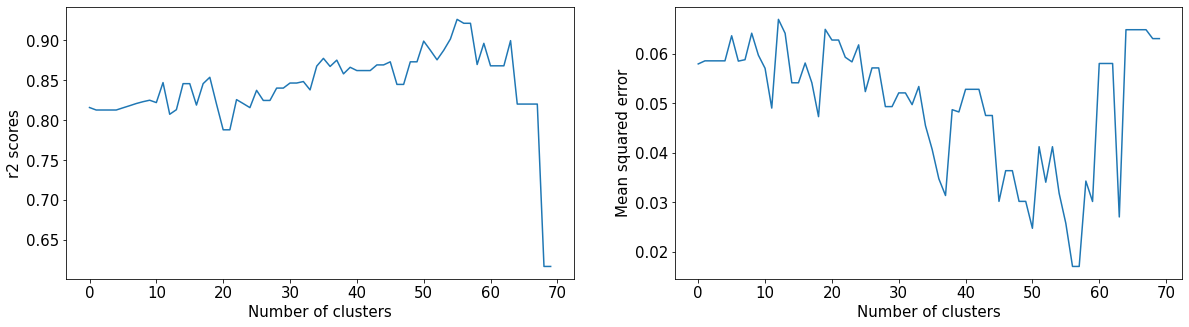

In [113]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(r2_scores)
plt.ylabel('r2 scores', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

plt.subplot(1,2,2)
plt.plot(RMSEs)
plt.ylabel('Mean squared error', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

In [106]:
np.max(r2_scores[0:20])

0.8539183191651283

Text(0.5, 0, 'Number of clusters')

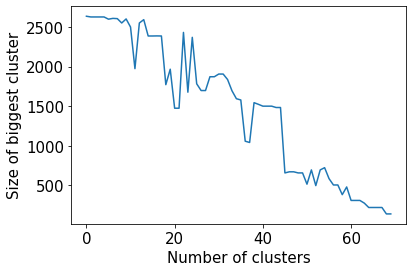

In [115]:
plt.plot(len_cluster)
plt.ylabel('Size of biggest cluster', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

Text(0.5, 0, 'Number of clusters')

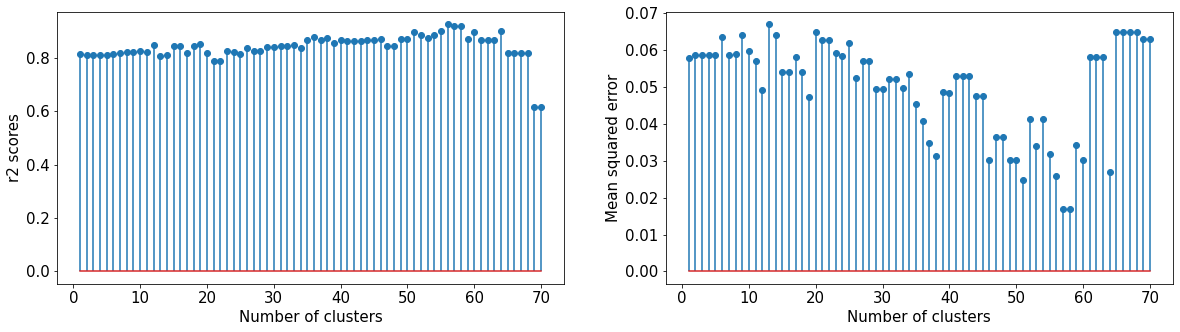

In [114]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.stem(range(1,max_clusters+1),r2_scores, use_line_collection=True)
plt.ylabel('r2 scores', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

plt.subplot(1,2,2)
plt.stem(range(1,max_clusters+1),RMSEs, use_line_collection=True)
plt.ylabel('Mean squared error', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)

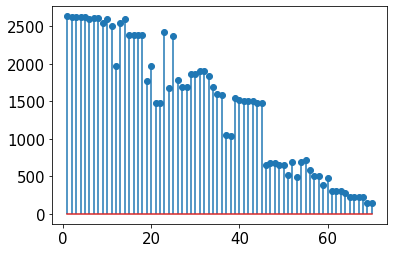

In [111]:
plt.stem(range(1,max_clusters+1),len_cluster, use_line_collection=True)
plt.show()

<h3>Conclusion:</h3>

We have tried to improve the performance of the linear regression with the use of the Foursquare data and the clustering algorithm on this data. We can see that based on the feature log living area only, the regression performs good with a r2 score of almost 0.73, this can be significantly improved to 0.80 by adding the number of venues in that area, feature which we have extracted from the Foursquare data. We have seen that, as expected, there is no correlation and no improvement in adding the raw cluster labels to the model. However, if we run the linear regression on the biggest cluster (in the case of 10 clusters) we have a significant improvement in the r2 score to more than 0.82, by doing this we have to discard some data, which however accounts to less than 2\% of the data.
	We can conclude that it is indeed possible to improve the performance of the linear regression by adding the Foursquare data, we have found two ways to do this, the best models among the ones we have run, are the simple ones which uses the log living area and number of venues features only. We have explored only some ways to improve the linear regression model, future research might include using the cluster labels and the Foursquare data in different ways.